# Score Distribution Example
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Dec 20, 2021

In [124]:
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from pycaret.classification import *

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [125]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [140]:
lkupclientid = 5 # trail blazers
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrTrailBlazers].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(27489, 54)

### We should specify the features used in our model:

In [141]:
# choose the features for the stellar base retention model
features = [
    "dimCustomerMasterId",
    "attendancePercent",
    "distToVenue",
    "isNextYear_Buyer",
    "productGrouping",
    "recency",
    "source_tenure",
    "totalSpent",
    "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (18594, 9)
Unseen Data For Predictions: (3281, 9)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [142]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancePercent",
        "distToVenue",
        "recency",
        "source_tenure",
        "totalSpent"
    ]
);

### Let's compare all models to evaluate performance. The output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time.

In [143]:
model_matrix = compare_models(
    fold=10,
    exclude=["lda","qda"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7652,0.8287,0.8339,0.8052,0.8192,0.4846,0.4854,0.5180
xgboost,Extreme Gradient Boosting,0.7637,0.8268,0.8326,0.8041,0.8180,0.4815,0.4823,0.3140
gbc,Gradient Boosting Classifier,0.7612,0.8256,0.8480,0.7924,0.8192,0.4687,0.4712,0.1040
ada,Ada Boost Classifier,0.7539,0.8200,0.8441,0.7860,0.8140,0.4516,0.4543,0.0490
knn,K Neighbors Classifier,0.7379,0.7759,0.8245,0.7781,0.8005,0.4191,0.4207,0.1480
lr,Logistic Regression,0.7363,0.7978,0.8561,0.7608,0.8055,0.4004,0.4077,0.3090
rf,Random Forest Classifier,0.7334,0.7839,0.8180,0.7764,0.7965,0.4105,0.4121,0.2380
et,Extra Trees Classifier,0.7208,0.7483,0.8007,0.7708,0.7854,0.3865,0.3873,0.2100
dt,Decision Tree Classifier,0.6957,0.6819,0.7483,0.7688,0.7583,0.3477,0.3481,0.0140
ridge,Ridge Classifier,0.6508,0.0000,0.9941,0.6474,0.7841,0.0499,0.1356,0.0070


In [144]:
models = {
    "et" : create_model('et'),
    "lightgbm" : create_model('lightgbm'),
    "xgboost" : create_model('xgboost')
}

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7660,0.8315,0.8236,0.8123,0.8179,0.4905,0.4906
1,0.7628,0.8245,0.8394,0.7991,0.8188,0.4763,0.4775
2,0.7672,0.8244,0.8464,0.8004,0.8227,0.4846,0.4863
3,0.7470,0.8082,0.8028,0.8012,0.8020,0.4517,0.4517
4,0.7551,0.8190,0.8304,0.7949,0.8122,0.4606,0.4615
5,0.7722,0.8250,0.8631,0.7967,0.8286,0.4906,0.4941
6,0.7785,0.8476,0.8442,0.8151,0.8294,0.5138,0.5145
7,0.7658,0.8283,0.8234,0.8121,0.8177,0.4903,0.4904
8,0.7753,0.8372,0.8373,0.8155,0.8262,0.5086,0.5089
9,0.7475,0.8224,0.8155,0.7942,0.8047,0.4477,0.4480


### Let's load in our 2021 season data and get retention scores using the model:

In [145]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape

(5614, 9)

In [146]:
et_predictions = predict_model(models.get('et'), data=df_inference, raw_score=True)
lightgbm_predictions = predict_model(models.get('lightgbm'), data=df_inference, raw_score=True)
xgboost_predictions = predict_model(models.get('xgboost'), data=df_inference, raw_score=True)

et distribution:


array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

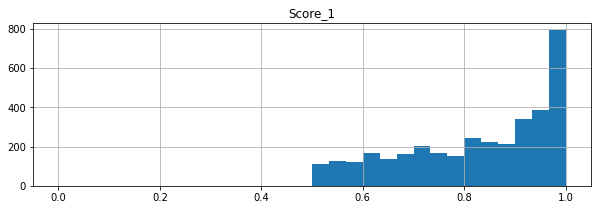

In [159]:
print("et distribution:")
et_predictions[et_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,3), range=[0,1])

lightgbm distribution:


array([[<AxesSubplot:title={'center':'Score_1'}>]], dtype=object)

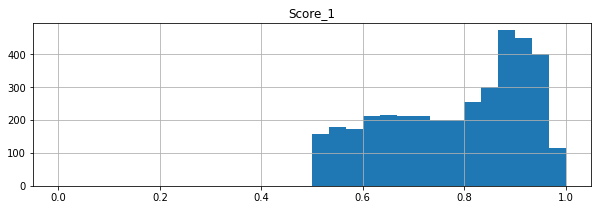

In [160]:
print("lightgbm distribution:")
lightgbm_predictions[lightgbm_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,3), range=[0,1])

In [ ]:
print("xgboost distribution:")
xgboost_predictions[xgboost_predictions["Label"]==1][["Score_1"]].hist(bins=30, figsize=(10,3), range=[0,1])